# Naive Bayes with sklearn

We saw in class that Naive Bayes is a probabilistic classifier, that can easily support categorical and quantitative variables.

Problem is ... `sklearn` does not natively work with both ...

We will need to split again our data in quantitative and qualitative, and then code our own suggestions to take both into account.

You can start with quantitative or qualitative data depending on the majority data type in your dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.naive_bayes import GaussianNB, CategoricalNB

In [2]:
# My target is shot_made_flag 

df = pd.read_csv("../Datasets/kobe.csv")
data_process = df.dropna().reset_index()

minutes = data_process["minutes_remaining"].values
secondes = data_process["seconds_remaining"].values
temps_restant = pd.Series((minutes*60 + secondes), name="temps_restant")

qualitative_vars = ["action_type", "combined_shot_type", "game_event_id", "game_id", "period", "playoffs", "season", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range", "team_name", "game_date", "matchup", "opponent"]
quantitative_vars = [col for col in data_process.columns if col not in qualitative_vars + ["shot_made_flag", "shot_id", 'team_id', "minutes_remaining", "seconds_remaining"]]  # garder le shot_id ?

data_process = data_process.drop(columns=["minutes_remaining","seconds_remaining"], axis=1)
print(data_process.columns)
quantitative_vars.append("temps_restant")
data = pd.concat([data_process, temps_restant], axis=1)
X = data[qualitative_vars + quantitative_vars].values
X_quantitative = data[quantitative_vars].values
X_categorical = data[qualitative_vars].values
y = data_process["shot_made_flag"].values

feature_names = quantitative_vars + qualitative_vars

Index(['index', 'action_type', 'combined_shot_type', 'game_event_id',
       'game_id', 'lat', 'loc_x', 'loc_y', 'lon', 'period', 'playoffs',
       'season', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'team_id',
       'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')


## Working with quantitative data
With quantitative data, we can use the `GaussianNB` class.

In [29]:
# Entraînement du modèle Naïve Bayes gaussien
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_quantitative, y)

# Prédiction sur les données d'entraînement
predictions = gaussian_nb.predict(X_quantitative)

# Affichage du rapport de classification
print("======= Results")
print(classification_report(y, predictions))

# Récupération des moyennes (thêta) et des variances (sigma)
means = gaussian_nb.theta_
variances = gaussian_nb.var_

# Calcul de l'importance des caractéristiques en fonction de la différence entre les moyennes ou les variances
importance = np.abs(means[1] - means[0]) / np.sqrt(variances[0] + variances[1])

# Triez les caractéristiques en fonction de leur importance
top_features_indices = np.argsort(importance)[::-1]
top_features = top_features_indices[:10]  # Sélection des 10 premières caractéristiques les plus importantes

# Affichage des caractéristiques les plus importantes
print("======= Top Features")
for idx in top_features:
    print(f"Feature {quantitative_vars[idx]}: Importance {importance[idx]}")

======= Results
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.63     14232
         1.0       0.53      0.52      0.53     11465

    accuracy                           0.58     25697
   macro avg       0.58      0.58      0.58     25697
weighted avg       0.58      0.58      0.58     25697

======= Top Features
Feature shot_distance: Importance 0.28753897369639225
Feature loc_y: Importance 0.21444077847834622
Feature lat: Importance 0.06331219275294216
Feature temps_restant: Importance 0.04387916532684627
Feature index: Importance 0.018513313738700334
Feature loc_x: Importance 0.0012154237219007397
Feature lon: Importance 0.0004412999986779825


In [26]:
mask = importance>0.06
sub_X_preprocess = X_quantitative[:,mask]
X_train, X_test, y_train, y_test = train_test_split(sub_X_preprocess, y,test_size=0.2, random_state=0)

In [32]:
sub_X_preprocess.shape

(25697, 3)

In [27]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)
predictions = gaussian_nb.predict(X_test)
print("======= Results")
print(classification_report(y_test, predictions))

======= Results
              precision    recall  f1-score   support

         0.0       0.62      0.54      0.58      2866
         1.0       0.50      0.59      0.54      2274

    accuracy                           0.56      5140
   macro avg       0.56      0.56      0.56      5140
weighted avg       0.57      0.56      0.56      5140



In [30]:
predictions = gaussian_nb.predict_proba(X_quantitative)

**Questions**:
1. Plot the statistical distribution of your variables and see if any is highly skewed.
2. Apply Gaussian Naive Bayes to the quantitative variables of your dataset.
3. Retrieve class probability and plot the results as a function of the different features, using heatmap colors.
4. Perform k-fold cross-validation and return the classification scores (accuracy, recall, precision).
6. Try removing highly correlated data and see if your results improve.

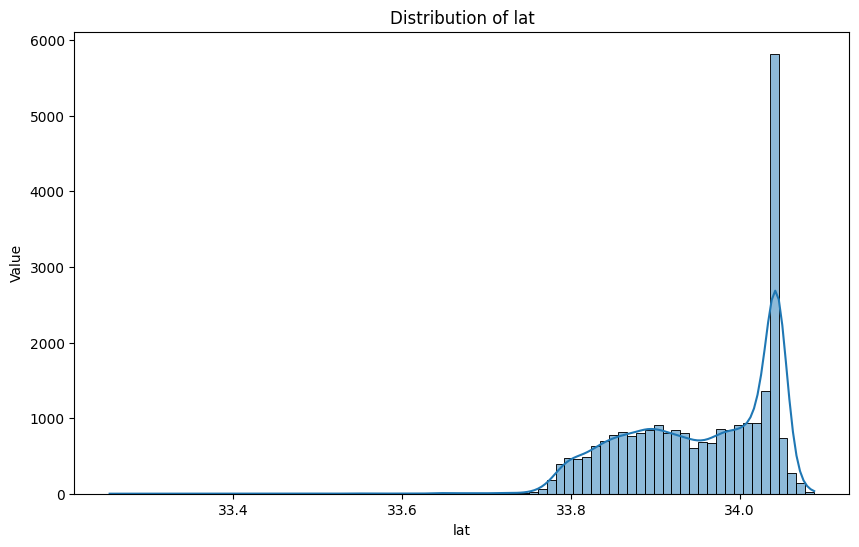

The skewness of lat is: -0.8406872678437134


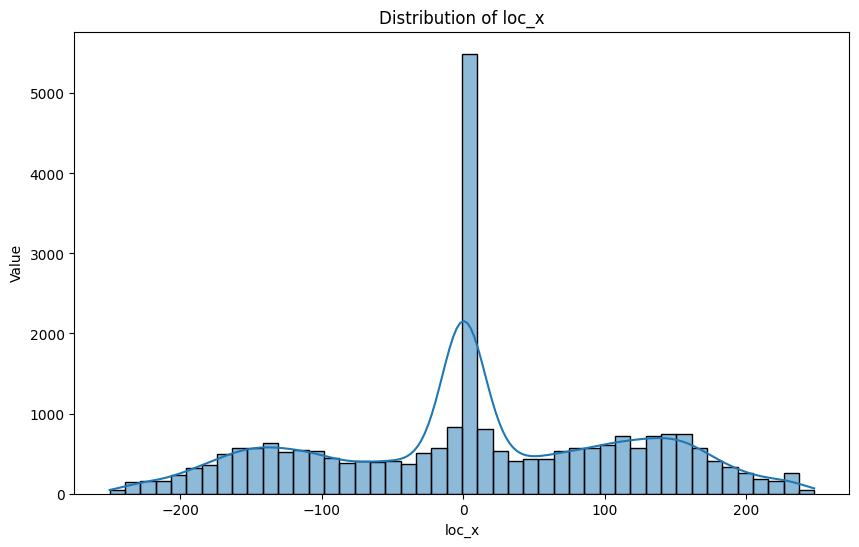

The skewness of loc_x is: -0.08493025787188782


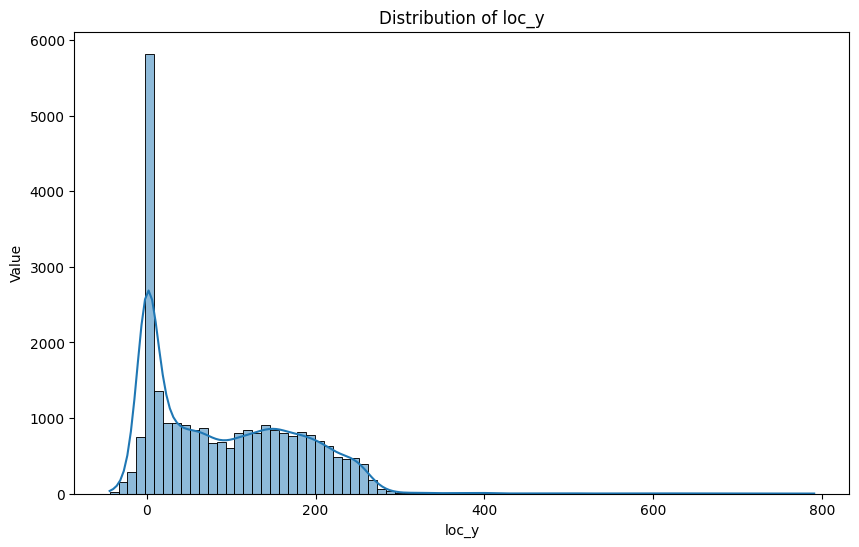

The skewness of loc_y is: 0.8406872678437728


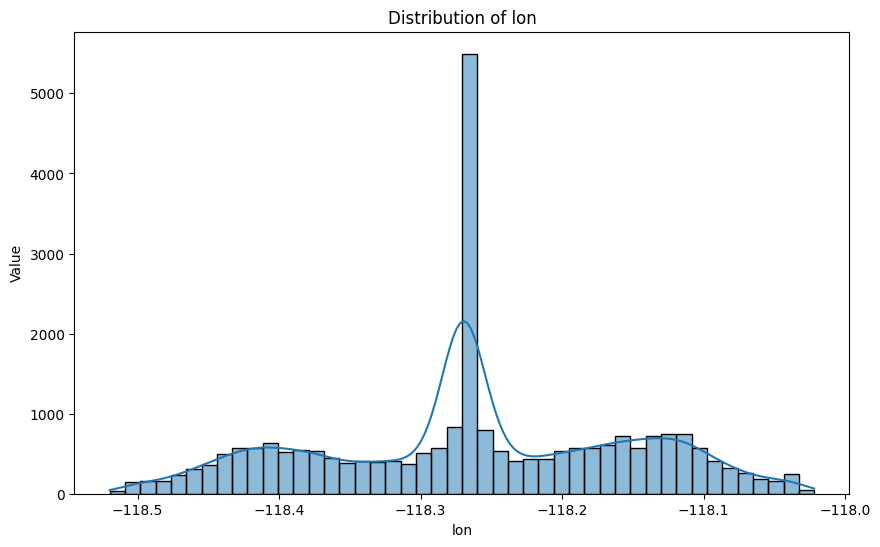

The skewness of lon is: -0.08493025787177458


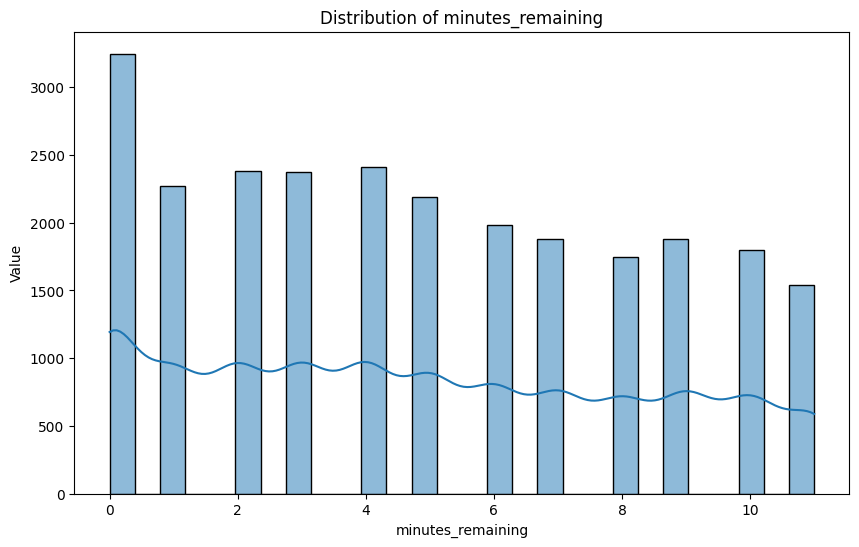

The skewness of minutes_remaining is: 0.19762442627108182


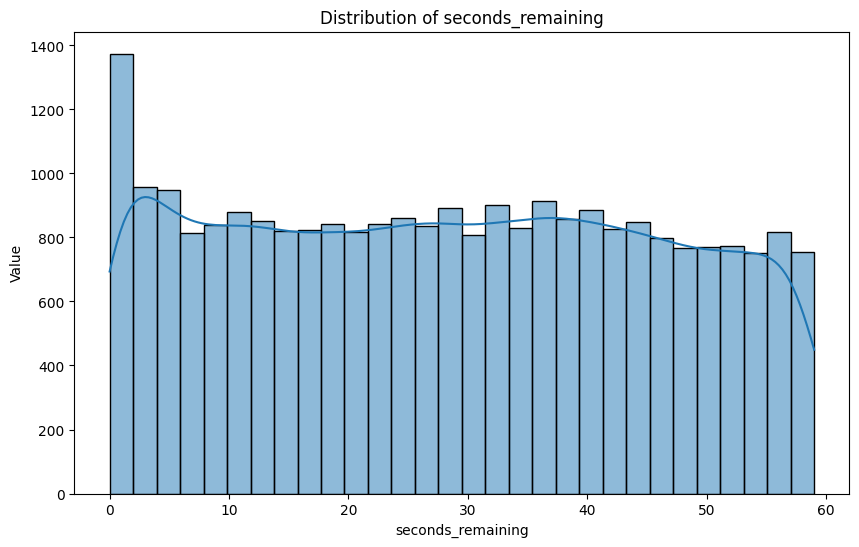

The skewness of seconds_remaining is: 0.03525222199685529


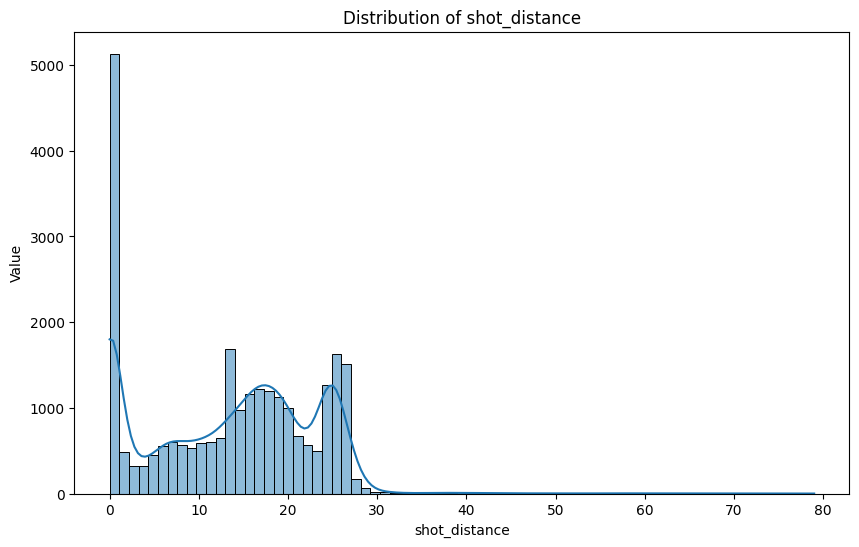

The skewness of shot_distance is: 0.12720932371341717


In [7]:
#Question 1
for column in data[quantitative_vars].columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=True)  # kde parameter adds a Kernel Density Estimate to smooth the histogram
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.show()

    # Calculate and print skewness
    skewness = data[column].skew()
    print(f"The skewness of {column} is: {skewness}")

    # You might define a threshold for skewness, for instance 1 or -1
    if skewness > 1 or skewness < -1:
        print(f"{column} is highly skewed")

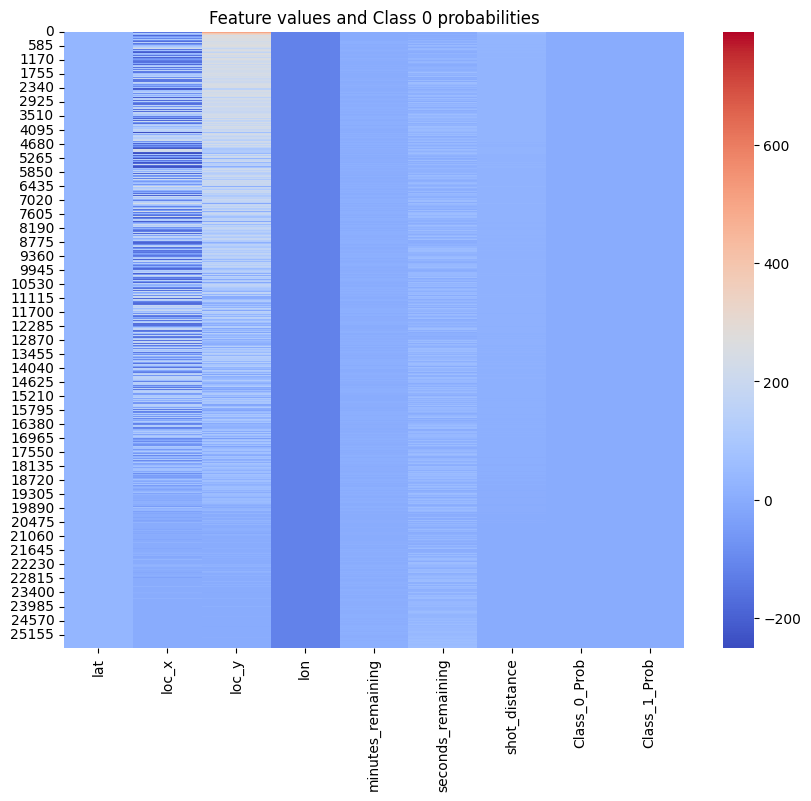

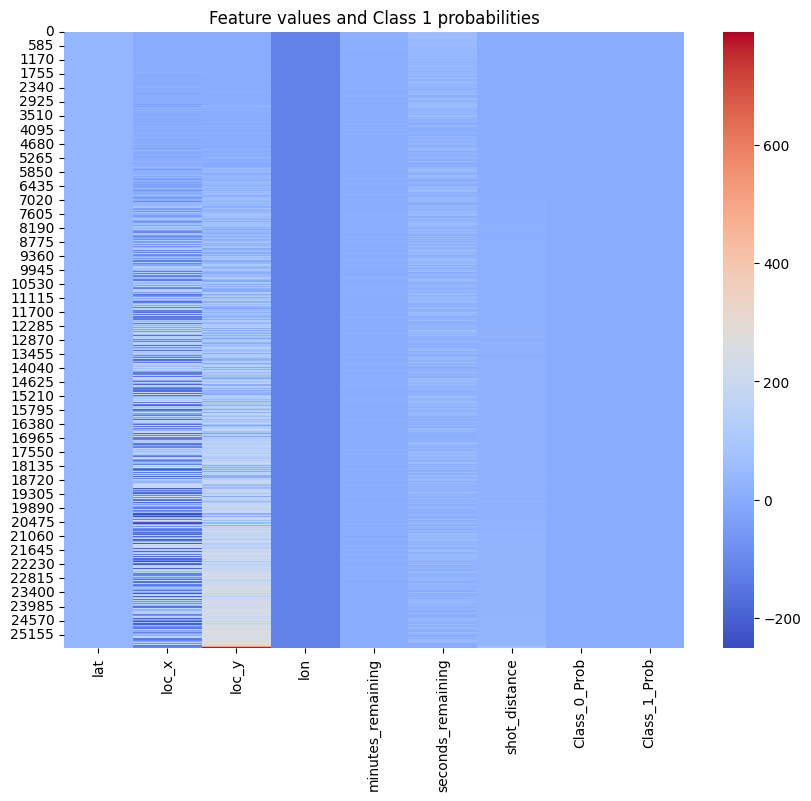

In [46]:
#3 (nous, et c'est pas bon)
#reconvertir en data frame car généralement des fonctions existent qu'avec pandas
prob_df = pd.DataFrame(predictions, columns=[f'Class_{class_idx}_Prob' for class_idx in range(predictions.shape[1])])
feature_df = pd.DataFrame(X_quantitative, columns=quantitative_vars)
heatmap_df = pd.concat([feature_df, prob_df], axis=1)

for class_idx in range(predictions.shape[1]):
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df.sort_values(by=f'Class_{class_idx}_Prob', ascending=False).reset_index(drop=True), cmap='coolwarm')
    plt.title(f'Feature values and Class {class_idx} probabilities')
    plt.show()

<Axes: >

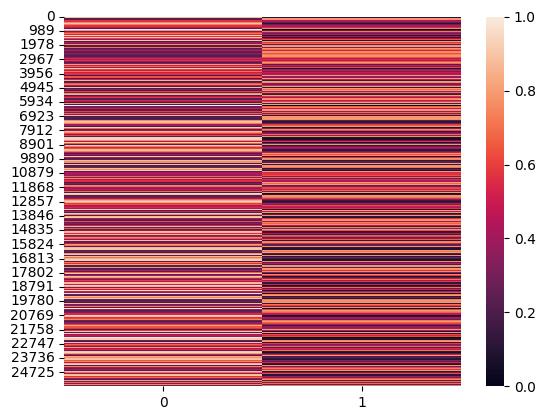

In [8]:
#question 3 corrigée
predicted_proba = gaussian_nb.predict_proba(X_quantitative)
sns.heatmap(predicted_proba)

In [55]:
quantitative_vars

['lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'seconds_remaining',
 'shot_distance']

Text(0, 0.5, 'shot_distance')

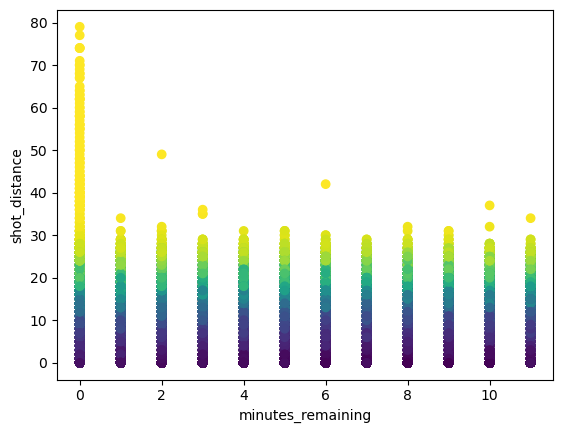

In [6]:
predicted_proba = gaussian_nb.predict_proba(X_quantitative)
plt.scatter(X_quantitative[:,4], X_quantitative[:,6],c=predicted_proba[:,0])
plt.xlabel(quantitative_vars[4])
plt.ylabel(quantitative_vars[6])

Text(0, 0.5, 'lon')

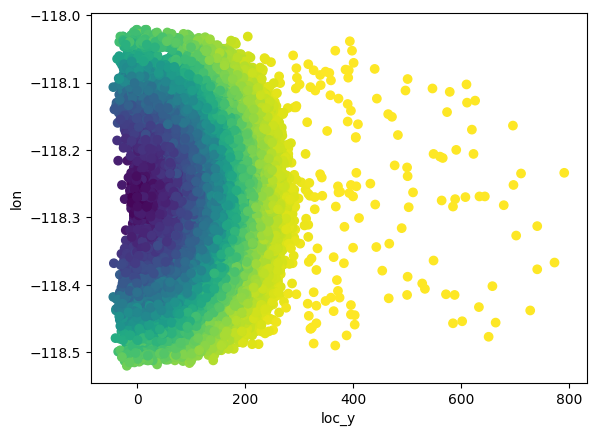

In [10]:
plt.scatter(X_quantitative[:,2], X_quantitative[:,3],c=predicted_proba[:,0])
plt.xlabel(quantitative_vars[2])
plt.ylabel(quantitative_vars[3]) 
#On voit que toute la zone verte correspond à une zone où les variables sont pas du tout discriminantes (En déduire Naive Bais pas du tout adapté à mon modèle)

NameError: name 'predicted_proba' is not defined

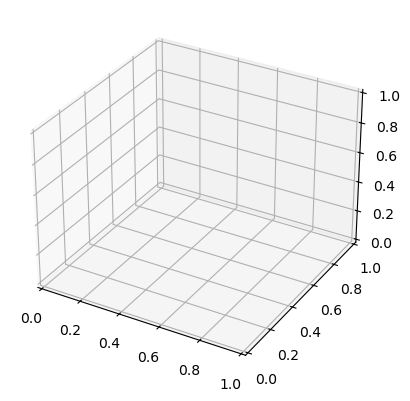

In [31]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Supposons que X_quantitative contienne 8 caractéristiques/features
# Ici, nous supposerons que vous souhaitez visualiser les probabilités prédites en fonction des trois premières caractéristiques.
# Modifiez les indices en fonction des caractéristiques que vous souhaitez visualiser.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = X_quantitative[:, 0]
y = X_quantitative[:, 1]
z = X_quantitative[:, 2]
c = predicted_proba[:, 0]  # Probabilités prédites pour la classe 0

ax.scatter(x, y, z, c=c, cmap='viridis')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()

In [7]:
# Question 4 :
gaussian_nb = GaussianNB()

print(f"== Working with accuracy")

scores = cross_val_score(estimator=gaussian_nb, X=X_quantitative, y=y)
print(f"Mean accuracy: {np.mean(scores)}")
print(f"Median accuracy: {np.median(scores)}")

print(f"== Working with precision")

scores = cross_val_score(estimator=gaussian_nb, X=X_quantitative, y=y, scoring="precision")

print(f"Mean precision: {np.mean(scores)}")
print(f"Median precision: {np.median(scores)}")

print(f"== Working with recall")

scores = cross_val_score(estimator=gaussian_nb, X=X_quantitative, y=y, scoring="recall")

print(f"Mean recall: {np.mean(scores)}")
print(f"Median recall: {np.median(scores)}")

== Working with accuracy
Mean accuracy: 0.5767992682795711
Median accuracy: 0.5787937743190662
== Working with precision
Mean precision: 0.5252189170826235
Median precision: 0.530622009569378
== Working with recall
Mean recall: 0.5536851286524204
Median recall: 0.5665067597034452


## Analyse bonus (mais très pertinente)
Il serait intéressant de tracer un histogramme par feature et par classe (shot réussi ou non). L'objectif est d'observer si les répartitions sont différentes selon la valeur de la target. Si pour une feature donnée il y a un gros écart entre les deux répartitions alors l'hypothèse du naive bayes est bonne. Le naive bayes suppose une répartition des donnée. Donc une feature correspondra bien à l'algorithme si on observe cela. 
Dans le cas contraire, si les répartitions sont similaire alors la feature n'est pas discriminante pour le naive bayes. On pourra alors en déduire que cet algortihme n'est surement pas adapté à notre jeu de données.

On pourra donc mettre en relation ces analyses avec les calculs d'accuracy, precision, recall

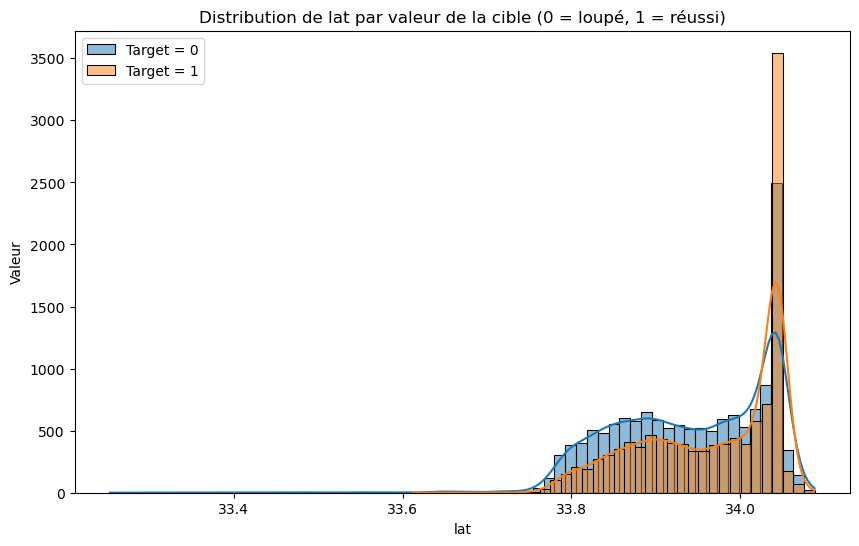

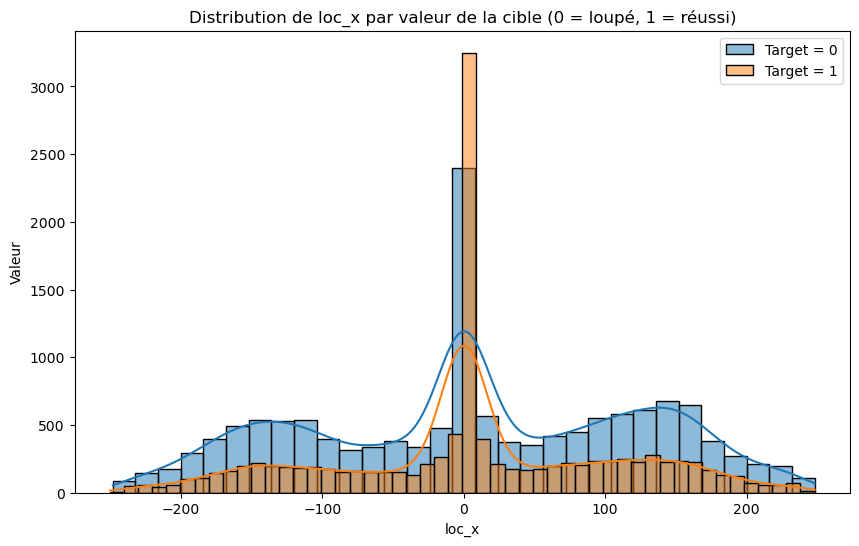

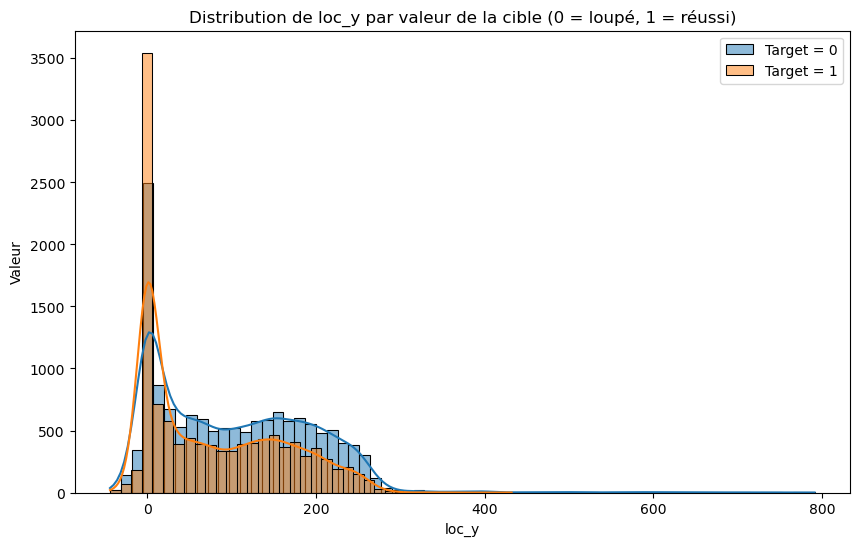

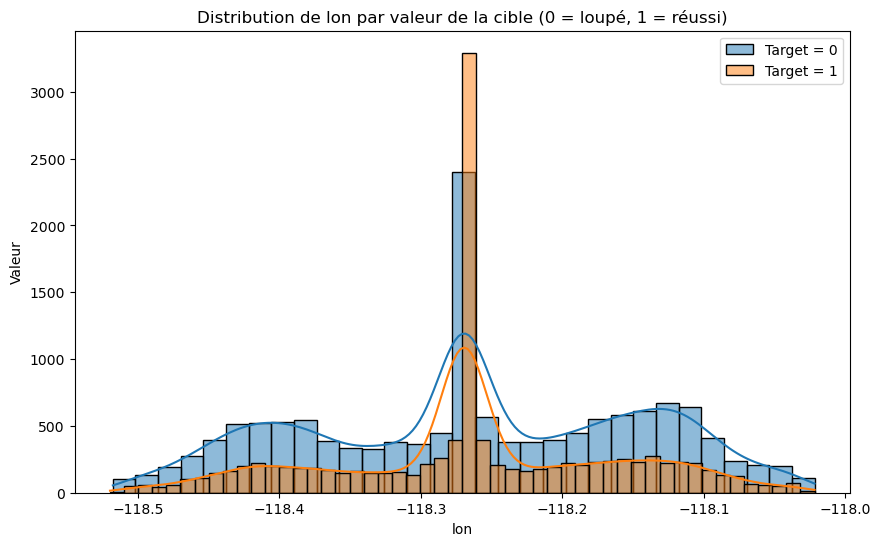

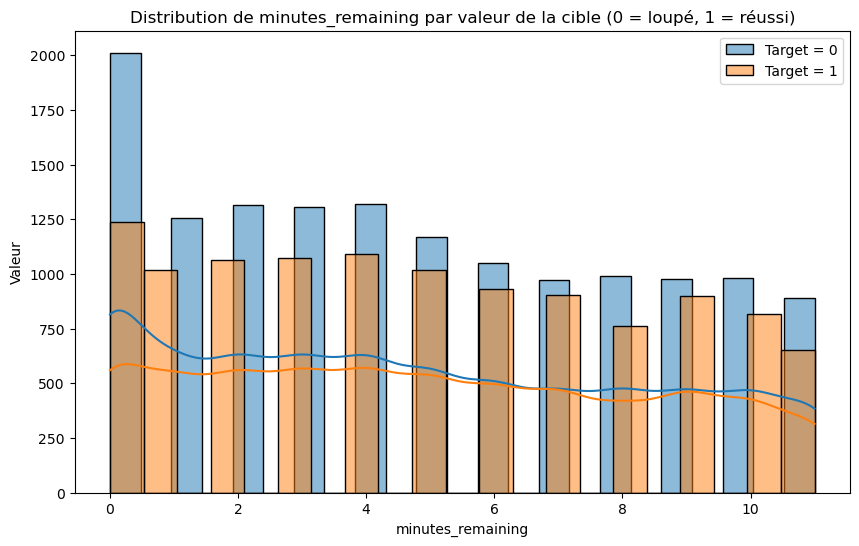

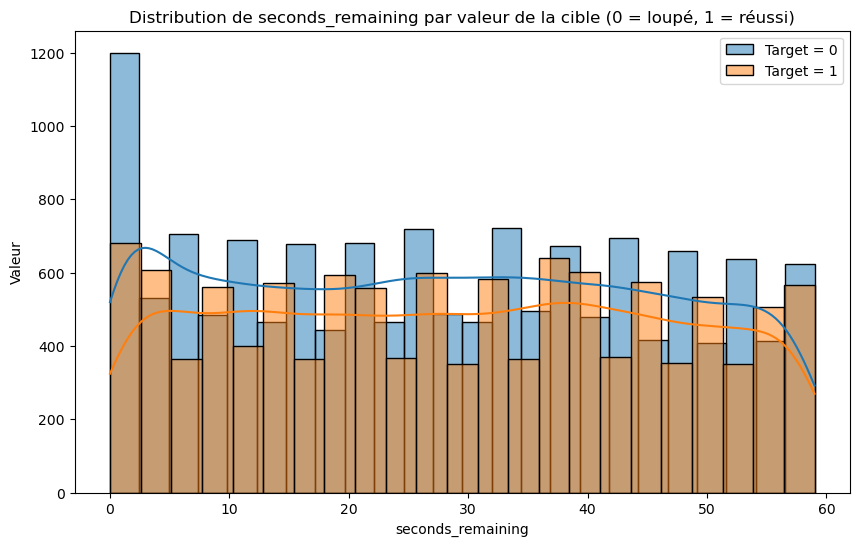

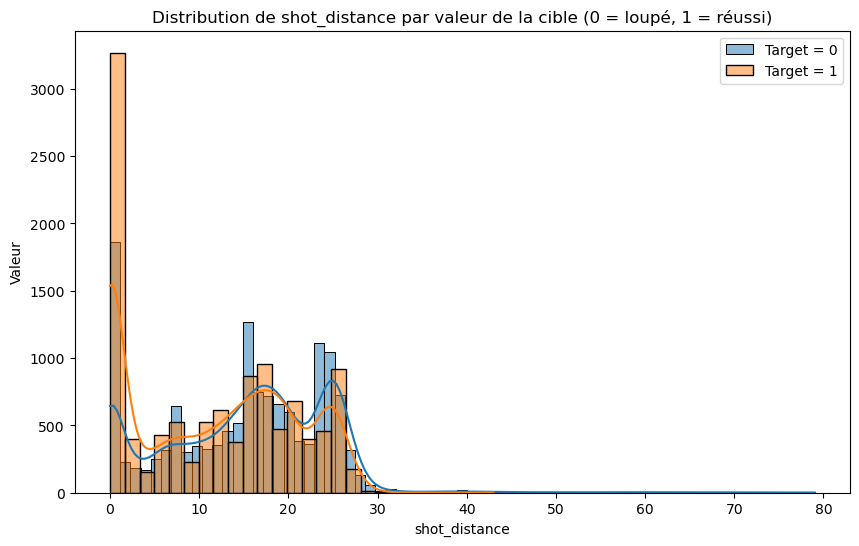

In [8]:
for column in data[quantitative_vars].columns:
    plt.figure(figsize=(10, 6))
    
    # Diviser les données en deux groupes basés sur les valeurs de la cible (0 ou 1) avec 0 = loupé, 1 = réussi
    for valeur_target in [0, 1]:
        subset_data = data[data['shot_made_flag'] == valeur_target]
        sns.histplot(subset_data[column], kde=True, label=f'Target = {valeur_target}')  # Le paramètre kde ajoute une estimation de la densité du noyau pour lisser l'histogramme
    
    plt.title(f'Distribution de {column} par valeur de la cible (0 = loupé, 1 = réussi)')
    plt.xlabel(column)
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()

On peut donc analyser que le naive Bayes considère que les répartitions suivent la même loi. L'algorithme ne peut donc pas discriminer à l'aide des feature. Il est donc pas intéressant d'utiliser un algorithme se basant sur des probabilités quand les variables ressemblent à ceci. Ces données sont donc un cas d'usage de pourquoi NE PAS utiliser Naive Bayes. 
Il est très important de faire apparaitre ces graphes et l'analyse dans notre rendu puisqu'ils justifient (en plus de l'accuracy...) pourquoi ne pas utiliser naive Bayes.

## A Faire /!\ enlever les données très corrélées (travail maison)
c'est la question 5

## Working with qualitative data
With qualitative data, we can use the class CategoricalNB.

In [21]:
encoder = LabelEncoder()
encoded_vars = []
for category in X_categorical.T:
    encoded_vars.append(encoder.fit_transform(category))

In [22]:
X_cat = np.array(encoded_vars).T

In [23]:
gaussian_nb_categorical = CategoricalNB()

print("======= Training")
gaussian_nb_categorical.fit(X_cat, y)

print("======= Prediction")
predictions = gaussian_nb_categorical.predict(X_cat)

print("======= Results")
print(classification_report(y, predictions))

======= Training
======= Prediction
======= Results
              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71     14232
         1.0       0.64      0.55      0.59     11465

    accuracy                           0.66     25697
   macro avg       0.66      0.65      0.65     25697
weighted avg       0.66      0.66      0.66     25697



**Questions**:
1. Apply Gaussian Naive Bayes to the qualitative variables of your dataset.
3. Retrieve class probability and plot the results as a function of the different features, using heatmap colors.
4. Perform k-fold cross-validation and return the classification scores (accuracy, recall, precision).
5. Compare to previous results.
6. Transform every variable within your dataset to a qualitative using the class `sklearn.preprocessing.KBinsDiscretizer` and compare with previous results.
7. Compare to what you achieved using `knn`.

<Axes: >

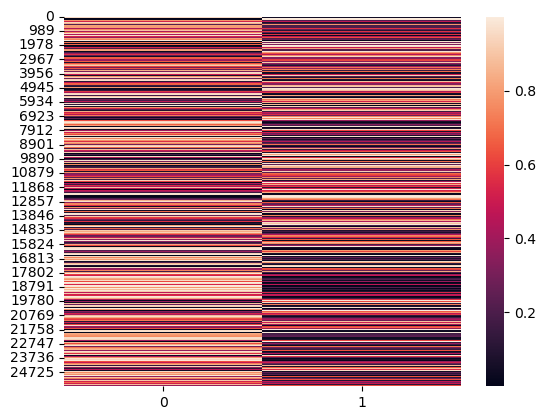

In [15]:
#2
predicted_proba = gaussian_nb_categorical.predict_proba(X_cat)
sns.heatmap(predicted_proba)

In [29]:
#3 
# evaluate a logistic regression model using k-fold cross-validation

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

print(f"== Working with accuracy")

scores = cross_val_score(estimator=gaussian_nb, X=X_cat, y=y, cv=cv)
print(f"Mean accuracy: {np.mean(scores)}")
print(f"Median accuracy: {np.median(scores)}")

print(f"== Working with precision")

scores = cross_val_score(estimator=gaussian_nb, X=X_cat, y=y, scoring="precision")

print(f"Mean precision: {np.mean(scores)}")
print(f"Median precision: {np.median(scores)}")

print(f"== Working with recall")

scores = cross_val_score(estimator=gaussian_nb, X=X_cat, y=y, scoring="recall")

print(f"Mean recall: {np.mean(scores)}")
print(f"Median recall: {np.median(scores)}")

== Working with accuracy
Mean accuracy: 0.636027395600743
Median accuracy: 0.6365051566452617
== Working with precision
Mean precision: 0.6289963792205819
Median precision: 0.6261203585147247
== Working with recall
Mean recall: 0.4434365460095944
Median recall: 0.43959877889228083


## Working with both data types
It is annoying that sklearn does not allow to deal with both variables types...

A solution to solve this is to:
- Fit a GaussianNB on the quantitative variables and get the probabilities `quantitative_probabilities`
- Fit a CategoricalNB on the qualitative variables `qualitative_probabilities`
- Fit a new GaussianNB on the probbailities `quantitative_probabilities` and `qualitative_probabilities`.

**Question**:
1. Implement this solution and compare the results with what you obtained previously.
2. **Bonus**: Suggest your own implementation using `sklearn` API for classifiers (see https://scikit-learn.org/stable/developers/develop.html).


In [42]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_quantitative, y)
quantitative_probabilities = gaussian_nb.predict_proba(X_quantitative)
print(quantitative_probabilities)

gaussian_nb_categorical = CategoricalNB()
gaussian_nb_categorical.fit(X_cat, y)
qualitative_probabilities = gaussian_nb_categorical.predict_proba(X_cat)
print(qualitative_probabilities)

[[0.50886411 0.49113589]
 [0.58905115 0.41094885]
 [0.77516432 0.22483568]
 ...
 [0.77789537 0.22210463]
 [0.93659587 0.06340413]
 [0.3389921  0.6610079 ]]
[[0.71931518 0.28068482]
 [0.77433987 0.22566013]
 [0.58312333 0.41687667]
 ...
 [0.81484029 0.18515971]
 [0.97854631 0.02145369]
 [0.88375071 0.11624929]]


In [47]:
# Combiner les probabilités quantitatives et qualitatives
combined_probabilities = np.concatenate((quantitative_probabilities, qualitative_probabilities), axis=1)

# Entraîner un nouveau modèle GaussianNB sur les probabilités combinées
new_gaussian_nb = GaussianNB()
new_gaussian_nb.fit(combined_probabilities, y)
predictions = gaussian_nb.predict(X_cat)

print(classification_report(y, predictions))

ValueError: X has 15 features, but GaussianNB is expecting 7 features as input.

In [48]:
combined_probabilities

array([[0.50886411, 0.49113589, 0.71931518, 0.28068482],
       [0.58905115, 0.41094885, 0.77433987, 0.22566013],
       [0.77516432, 0.22483568, 0.58312333, 0.41687667],
       ...,
       [0.77789537, 0.22210463, 0.81484029, 0.18515971],
       [0.93659587, 0.06340413, 0.97854631, 0.02145369],
       [0.3389921 , 0.6610079 , 0.88375071, 0.11624929]])

In [60]:
# Next step to do: use train / test or cross val approach using this method.